Filtern

Wir importieren die notwendigen Bibliotheken.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans

Als erstes wird die CSV Datei importiert und als Dataframe abgelegt.

In [2]:
url = 'C:/Users/oache/Desktop/KI_ML/vehicles/vehicles.csv'
#url= 'C:/Users/nicof/OneDrive/Dokumente/FH-München/KI\Modularbeit/archive/vehicles.csv'
df = pd.read_csv(url)


Als nächstes lassen wir uns die ersten fünf Einträge anzeigen, um einen Überblick über die Daten zu erlangen. Es fällt auf, dass einige der Spalten für die Vorhersage des Preises nicht von nutzen sein werden.

In [3]:
df.head()


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


Um einen Überblick zu bekommen mit wievielen Daten wir uns beschäftigen lassen wir uns die Dimensionen des Dataframes anzeigen. Wir haben ein Datenfeld in der größe 426880 x 26

In [4]:
df.shape

(426880, 26)

Um eine Überblick über die Fahrzeughersteller und deren Inseratanteilen zu bekommen lassen wir uns dies anhande der Stückzahlen anzeigen.

<BarContainer object of 42 artists>

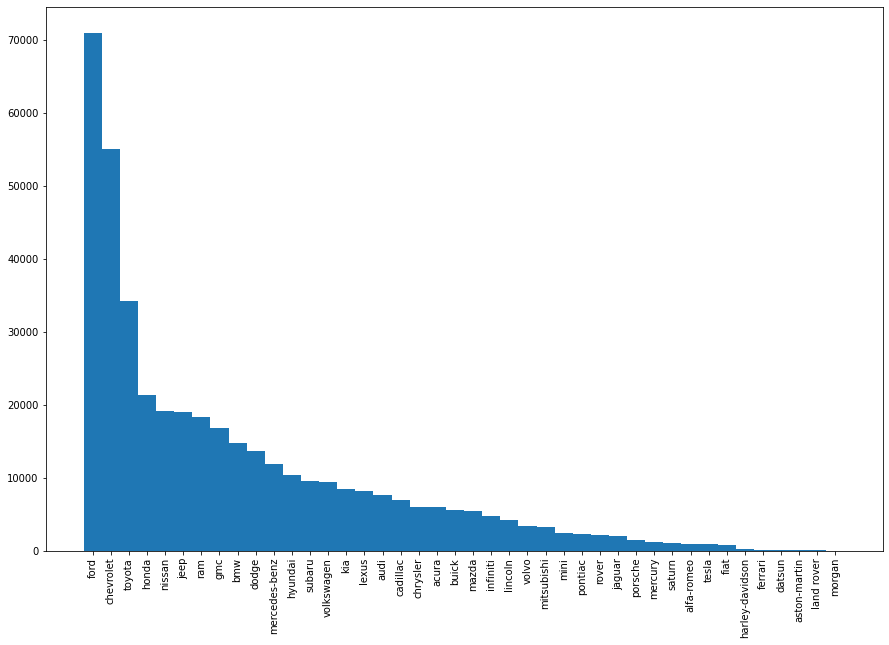

In [5]:
x = (df.groupby(['manufacturer'],as_index = False).count().sort_values('price', ascending = False))['manufacturer'].tolist()
y = (df.groupby(['manufacturer'],as_index = False).count().sort_values('price', ascending = False))['price'].tolist()
fig = plt.figure(figsize=(15,10))
plt.xticks(rotation = 90)
plt.bar(x, y, width=1)

Wir lassen uns die unterschiedlichen Angaben zu den jeweiligen Kategorien anzeigen.

In [6]:
print(df["paint_color"].unique())
print(df["condition"].unique())
print(df["type"].unique())
print(df["fuel"].unique())
print(df["cylinders"].unique())
print(df["title_status"].unique())
print(df["type"].unique())
print(df["drive"].unique())
print(df["transmission"].unique())

[nan 'white' 'blue' 'red' 'black' 'silver' 'grey' 'brown' 'yellow'
 'orange' 'green' 'custom' 'purple']
[nan 'good' 'excellent' 'fair' 'like new' 'new' 'salvage']
[nan 'pickup' 'truck' 'other' 'coupe' 'SUV' 'hatchback' 'mini-van' 'sedan'
 'offroad' 'bus' 'van' 'convertible' 'wagon']
[nan 'gas' 'other' 'diesel' 'hybrid' 'electric']
[nan '8 cylinders' '6 cylinders' '4 cylinders' '5 cylinders' 'other'
 '3 cylinders' '10 cylinders' '12 cylinders']
[nan 'clean' 'rebuilt' 'lien' 'salvage' 'missing' 'parts only']
[nan 'pickup' 'truck' 'other' 'coupe' 'SUV' 'hatchback' 'mini-van' 'sedan'
 'offroad' 'bus' 'van' 'convertible' 'wagon']
[nan 'rwd' '4wd' 'fwd']
[nan 'other' 'automatic' 'manual']


Um einen Überblick zu erhalten, wie oft in der jeweiligen Kategorie kein Eintrag vorhanden ist lassen wir uns dies Anzeigen.

In [7]:
df.isnull().sum().sort_values(ascending = False)

county          426880
size            306361
cylinders       177678
condition       174104
VIN             161042
drive           130567
paint_color     130203
type             92858
manufacturer     17646
title_status      8242
lat               6549
long              6549
model             5277
odometer          4400
fuel              3013
transmission      2556
year              1205
description         70
image_url           68
posting_date        68
url                  0
price                0
state                0
region_url           0
region               0
id                   0
dtype: int64

Um die Vorhersage des Preises präziser zu ermöglichen, entfernen wir die Spalten aus dem Dataframe die wir für unnötige erachten:
- county: extrem hohe Anzahl ein Nan einträgen.
- size: extrem hohe Anzahl ein Nan einträgen.
- id, url, region_url, lat, long, vin, image_url, description, geometry: Diese Angaben sind teilweise sehr individuell (z.B. description), oder für eine Preisvorhersage nicht relevant.
- size: Die "größe" des Fahrzeugs ist Modellabhängig und kann somit ebenfalls entfernt werden.
- region: Diese Angabe ist sehr präzise wir nutzen die Angaben in der Kategorie 'state' zur örtlichen Einschränkung.

In [8]:


df.drop([ 'id', 'url', 'region_url', 'lat', 'long', 'VIN', 'image_url',
         'description', 'county','size','region'], axis = 1, inplace = True)
df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date
0,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN
1,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN
2,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN
3,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN
4,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN


In der Kategorie "title_status" sind die Angaben [nan 'clean' 'rebuilt' 'lien' 'salvage' 'missing' 'parts only'] vorhanden.(siehe oben) Für eine Preisvorhersage von Fahrzeugen, können die Inserate mit dem Titel 'rebuilt' 'lien' 'salvage' 'missing' 'parts only' jedoch nicht verwendet werden. 

In [9]:

df = df[((df['title_status'] != 'missing') & (df['title_status'] != 'parts only') 
    & (df['title_status'] != 'salvage') & (df['title_status'] != 'rebuilt')
   & (df['title_status'] != 'lien'))]


Aussortieren von Inseraten mit unrealistischen Preisen

In [10]:
df = df[((df['price'] < 500000) & (df['price'] > 100))]

Jetzt lassen wir uns die Fahrzeuginserate anhand der Baujahre und des zugehörigen Preises anzeigen.

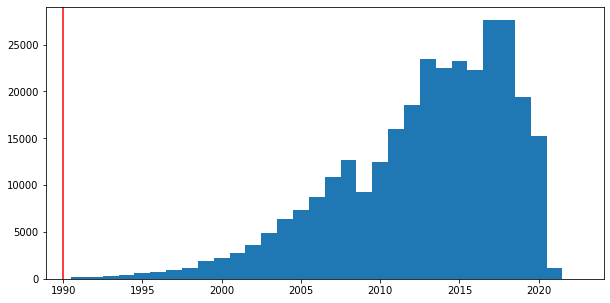

In [28]:
starting_year = 1990
x = (df.groupby(['year'],as_index = False).count())['year'].tolist()
y = (df.groupby(['year'],as_index = False).count())['price'].tolist()
fig = plt.figure(figsize=(10,5))
plt.bar(x, y, width=1)
plt.axvline(starting_year, color = 'red')

Die Anzahl an Fahrzeugen die vor 1990 gebaut wurden ist sehr gering und die Preise niedrig, für diese Fahrzeuge ist keine genau Preis Ermittlung möglich.

In [12]:

df = df[df['year'] > 1990]


Fahrzeuge mit sehr hohen Tachostand (höchsten 1%) können ebenfalls ignoriert werden.

In [13]:
top1 = np.nanpercentile(df['odometer'], 99)
df = df[df['odometer'] < top1]

Fahrzeuge die keine Angeben in den Spalten fuel, transmission, manufacturer und model können ebenfalls vernächlässigt werden, da diese Angaben hohe Priorität haben.

In [14]:
#delete unknown fuel, transmission and title_status instances

df.dropna(subset = ['fuel', 'transmission', 'title_status'], axis = 0, inplace = True)
df = df[~df['manufacturer'].isnull()]
df = df[~df['model'].isnull()]
df.shape

(334271, 15)

Um im späteren Verlauf eine Prediction zu ermöglichen ersetzen wir in den restlichen Spalten die Nan Angaben durch unknowen bzw. not specified

In [15]:
#replace missing condition values with 'not specified'

df['condition'].fillna('not specified', inplace = True)
df['paint_color'].fillna('unknown', inplace = True)


Da in einigen inseraten Modell verschieden beschrieben werden z.B. F150, F150 good condition, F-150 beschränken wir uns auf das erste Wort in der Beschreibung und entfernen alle Modelle die anschließend weniger als 150 mal auftreten. Desweitern fügen wir den manufacturer in der Spalte model hinzu, um zu vermeiden, dass Fahrzeuge die den gleichen Modellnamen jedoch von unterschiedlichen Herstellern sind, zusammengfügt werden. Dies machen wir in einem speraten Dataframe um uns die Unterschiede anzeigen lassen zu können

In [16]:


model_list = df['model'].tolist()
model_list = map(str, model_list)
model_list = [x.lower().strip() for x in model_list]
my_list = [car_model.split()[0] for car_model in model_list]
my_list = [x.replace(' ', '').replace('-', '').replace('/', '') for x in my_list]

df['car_model'] = my_list
df['car_model'] = df['manufacturer'] + " " + df['car_model']

new_car_models = (df.groupby(['car_model'], as_index= False).count())[['manufacturer', 'car_model', 'price']]
new_car_models = new_car_models.rename(columns={'price': 'count'})
only_common_models = new_car_models[new_car_models['count'] > 150]
#evtl löschen
print('Alle models ', len(new_car_models['count']))
print('models mit mehr als 150 Einträgen: ', len(only_common_models['count']))
print('Prozentualeranteil an gelöschten models:', round((1-len(only_common_models['count'])/len(new_car_models['count'])) * 100, 2))
print()
print('Gesamtanzahl an Inseraten: ', len(df['price']))
print('Verbleibende Inserate: ', sum(only_common_models['count']))
print('Prozentualeranteil an gelöschten Inseraten ', round((1-sum(only_common_models['count'])/len(df['price'])) * 100, 2))

Alle models  2459
models mit mehr als 150 Einträgen:  303
Prozentualeranteil an gelöschten models: 87.68

Gesamtanzahl an Inseraten:  334271
Verbleibende Inserate:  306723
Prozentualeranteil an gelöschten Inseraten  8.24


Um einen graphischen Überblick zu erhalten wieviele Fahrzeugemodell und Inserate gelöscht werden, wenn wir die mindest Anzahl auf 150 setzen lassen wir uns dies Anzeigen.

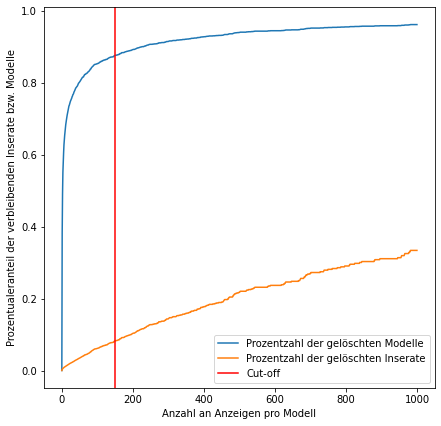

In [17]:
removed_models_list = []
removed_instances_list = []

for i in range(0,1000):
    only_common_models_v2 = new_car_models[new_car_models['count']>i]
    models_removed = 1-len(only_common_models_v2['count'])/len(new_car_models['count'])
    instances_removed = 1-sum(only_common_models_v2['count'])/len(df['price'])
    
    removed_models_list.append(models_removed)
    removed_instances_list.append(instances_removed)

fig = plt.figure(figsize=(7,7))
plt.plot(removed_models_list, label = 'Prozentzahl der gelöschten Modelle')
plt.plot(removed_instances_list, label = 'Prozentzahl der gelöschten Inserate')
plt.axvline(150 , color = 'red', label = 'Cut-off')
plt.ylabel('Prozentualeranteil der verbleibenden Inserate bzw. Modelle')
plt.xlabel('Anzahl an Anzeigen pro Modell')
plt.legend()

Wir sind mit unsere Grenze von min. 150 Fahrzeugen zufrieden, da noch genügend Daten für eine Preisvorhersage vorhanden sind und trotzdem stark genüg reduziert wurde um die Gefahr des overfittings zu veringern.
Wir übernehmen unsere Änderungen im Hauptdataframe.

In [18]:
df = df[df['car_model'].isin(only_common_models['car_model'].tolist())]
df.drop('model', axis = 1, inplace = True)


Wir lassen uns das aktuelle Datafield anzeigen um einen Überblick zubekommen.

In [19]:
df.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date,car_model
27,33590,2014.0,gmc,good,8 cylinders,gas,57923.0,clean,other,NaN,pickup,white,al,2021-05-04T12:31:18-0500,gmc sierra
28,22590,2010.0,chevrolet,good,8 cylinders,gas,71229.0,clean,other,NaN,pickup,blue,al,2021-05-04T12:31:08-0500,chevrolet silverado
29,39590,2020.0,chevrolet,good,8 cylinders,gas,19160.0,clean,other,NaN,pickup,red,al,2021-05-04T12:31:25-0500,chevrolet silverado
30,30990,2017.0,toyota,good,8 cylinders,gas,41124.0,clean,other,NaN,pickup,red,al,2021-05-04T10:41:31-0500,toyota tundra
31,15000,2013.0,ford,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al,2021-05-03T14:02:03-0500,ford f150


In der Splate cylinders ersetzen wir die Werte Nan durch den Median und löschen die Einträge mit der Angabe 'others'.

In [20]:
df = df[df['cylinders'] != 'other']
dftest = df.copy()
test = df[df['cylinders'].notnull()].copy()
test['cylinders'] = [int(cyl.split()[0]) for cyl in test['cylinders']]
med = test.groupby('car_model')['cylinders'].median()
merged = pd.merge(dftest, med, on = 'car_model', how = 'left')
merged['cylinders_y'].fillna(med.median(), inplace = True)
merged['cylinders_x'].fillna(merged['cylinders_y'], inplace = True)

li = []
for cyl in merged['cylinders_x']:
    if type(cyl) == str:
        li.append(cyl)
    else:
        li.append(str(int(cyl)) + " cylinders")

df['cylinders'] = li


Wir fügen in der Spalte "drive" bei Einträgen ohne Anagbe den am häuigst auftretenden Werte ein.

In [21]:
dftest = df.copy()
test = df[df['drive'].notnull()].copy()
mode = test.groupby('car_model')['drive'].agg(pd.Series.mode)
merged = pd.merge(dftest, mode, on = 'car_model', how = 'left')
merged['drive_x'].fillna(merged['drive_y'], inplace = True)

df['drive'] = merged['drive_x'].tolist()
df['drive'].unique()

array(['4wd', 'rwd', 'fwd'], dtype=object)

Selbiges führen wir für die Spalte "type" druch.

In [22]:
dftest = df.copy()
test = df[df['type'].notnull()].copy()
mode = test.groupby('car_model')['type'].agg(pd.Series.mode)
merged = pd.merge(dftest, mode, on = 'car_model', how = 'left')
merged['type_x'].fillna(merged['type_y'], inplace = True)

df['type'] = merged['type_x'].tolist()


Um zu überprüfen, ob keine weiteren Nan einträge in den Spalten vorhanden sind zählen wir die Einträge mit Nan in allen Kategorien

In [23]:
#all the missing values are handled

df.isnull().sum()

price           0
year            0
manufacturer    0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
state           0
posting_date    0
car_model       0
dtype: int64

Einträge die einen untypisch hohen Preis (dreifcher Durchschnittspreis) haben, entfernen wir ebenfalls aus dem Datensatz.

In [24]:
df = df[df['price'] < (3 * df.groupby('car_model')['price'].transform('mean'))]

Um eine Vorstellung zu bekommen wieviele Einträge und Spalten wir durch unsere Eingrenzungsmaßnahemn entferen konnten lassen wir uns erneut die Dimensionen des Dataframes anzeigen. Wir konnten von einem die Einträge im Dataframe von 426880 x 26 auf 309189 x 15 reduzieren.
Dies entspricht einer Kürzung von 117691 Zeilen und 11 Spalten.

In [25]:
df.shape

(304885, 15)

Wir erstellen eine Kopie des Dataframes um es erneut herstellen zukönnen. Und erstellen die csv Datei clean.

In [26]:
clean = df.copy()

In [27]:
df.to_csv('clean.csv', index = False)